In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pytpc
from pytpc.fitting.mcopt_wrapper import Minimizer
from pytpc.constants import *
import pytpc.simulation
import pytpc.tpcplot
import pytpc.vmedata
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import h5py
from scipy.interpolate import UnivariateSpline, interp1d
from scipy.optimize import differential_evolution, minimize, basinhopping, leastsq
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
#import cmaps
import yaml
import scipy
from copy import copy, deepcopy
from pytpc.utilities import find_exclusion_region, read_lookup_table
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from math import pi

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
with open('/home/chen/Real Data/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = pytpc.fitting.MCFitter(config)
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']

#gd = pytpc.fitting.GDescent(config)

In [4]:
#Good events for run_0102 are: 689 (not good ~37), 765 (good), 896 (good), 305 (perfect), 504 (not good ~65)
#575, 456, 299, 399
full = h5py.File('/home/chen/Real Data/clean_run_0102.h5', 'r')
evt_ID = 456
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]

xyzs = np.array(xyzs_h5)

In [5]:
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)

In [6]:
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_values = uvw.values

In [7]:
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
ctr0 = mcfitter.guess_parameters(prefit_res)
exp_pos = uvw_sorted[['u', 'v', 'w']].values.copy() / 1000


In [8]:
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
print(exp_hits)


[0. 0. 0. ... 0. 0. 0.]


In [9]:
minimizer = Minimizer(mcfitter.tracker, mcfitter.evtgen, num_iters, num_pts, red_factor)
#ctr = np.zeros([1,6])
#ctr[0] = ctr0
print(ctr0)

[ 0.          0.          0.81074393  2.28701101 -1.68776102  1.92709779]


Conjugate Gradient

In [10]:
def f(y):
    ctr = np.zeros([1,6])
    ctr[0] = y
    chi_result = minimizer.run_tracks(ctr, exp_pos, exp_hits)
    return sum(chi_result[0])
eps = np.sqrt(np.finfo(np.float).eps)
def jacobian(x):
    return scipy.optimize.approx_fprime(x,f,1e-13)

print(f(ctr0))
print(jacobian(ctr0))


63.359508835912884
[ -652.06506861  -115.39214029  3259.89901739   -79.22551504
   -95.71010651 -1273.43469103]


In [11]:
i = 1
def callbackF(x):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1    
    
results = scipy.optimize.minimize(f, ctr0, method="CG", jac=jacobian, callback=callbackF, options={'gtol': 30.0, 'eps':1e-13})    

   1 0.001696 0.000300 0.802264 2.287217-1.687512 1.930410 46.693054
   2 0.015059-0.002400 0.799600 2.286558-1.687247 1.929135 38.579004
   3 0.016295-0.002815 0.798801 2.286550-1.687155 1.930093 37.684537
   4 0.016662-0.005687 0.804317 2.286604-1.687417 1.940019 33.718631
   5 0.016706-0.005146 0.804165 2.286594-1.687455 1.941883 33.653060


In [12]:
cg = results.x

In [13]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(cg[0], cg[1], cg[2], cg[3], cg[4], cg[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)


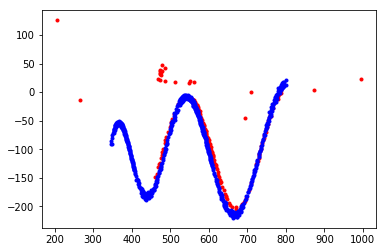

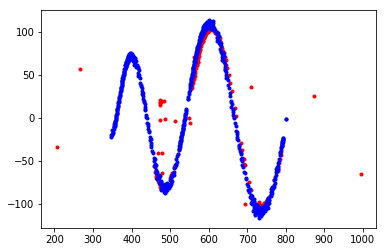

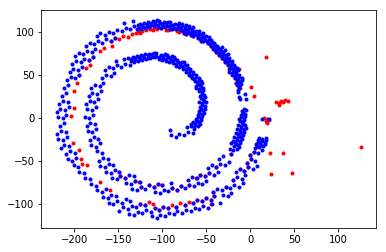

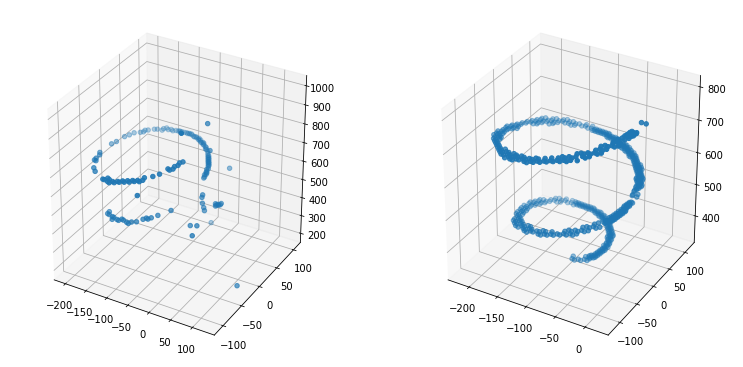

In [14]:
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,5],uvw_values[:,6],uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])

In [15]:
scipy.optimize.fmin_bfgs(f, ctr0)

         Current function value: 35.849328
         Iterations: 4
         Function evaluations: 690
         Gradient evaluations: 85


array([ 0.01923454, -0.00498603,  0.80168535,  2.28653169, -1.68695934,
        1.93428004])

Differential Evolution

In [16]:
i = 1
def callbackF(x, convergence=10):
    global i
    print('{0:4d}{1: 3.6f}{2: 3.6f}{3: 3.6f}{4: 3.6f}{5: 3.6f}{6: 3.6f}{7: 3.6f}'.format(i,x[0],x[1],x[2],x[3],x[4],x[5],f(x)))
    i += 1
bounds = [(-1,1), (-1, 1), (0, 1), (0,5), (-2 * pi, 2 * pi), (-2 * pi, 2 * pi)]
results = scipy.optimize.differential_evolution(f, bounds, callback=callbackF, maxiter=10000, strategy='best1bin')
'''    The differential evolution strategy should be one of:
            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result
            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result
            ‘rand1exp’ - takes a long time but converges
            ‘randtobest1exp’ - takes a long time but converges
            ‘currenttobest1exp’ - takes a long time but converges
            ‘best2exp’
            ‘rand2exp’
            ‘randtobest1bin’
            ‘currenttobest1bin’
            ‘best2bin’
            ‘rand2bin’
            ‘rand1bin’
    The default is ‘best1bin’.
'''

   1-0.015114-0.055518 0.640153 0.558615 3.310431-1.822191 174.413831
   2-0.027042-0.027191 0.766045 1.234416 5.126090 1.139176 133.869945
   3-0.000851-0.005998 0.767577 4.890313-1.112403 1.295514 104.678463
   4 0.008411 0.009775 0.755461 3.329761-3.935327 2.783831 101.300846
   5-0.001182 0.005151 0.705166 1.251794-2.721529 2.103477 96.529775
   6-0.001182 0.005151 0.705166 1.251794-2.721529 2.103477 96.529775
   7 0.009805-0.012646 0.863693 1.593884-5.024880 4.052063 84.751168
   8 0.009805-0.012646 0.863693 1.593884-5.024880 4.052063 84.751168
   9 0.009805-0.012646 0.863693 1.593884-5.024880 4.052063 84.751168
  10 0.009805-0.012646 0.863693 1.593884-5.024880 4.052063 84.751168
  11 0.009805-0.012646 0.863693 1.593884-5.024880 4.052063 84.751168
  12 0.009805-0.012646 0.863693 1.593884-5.024880 4.052063 84.751168
  13 0.009805-0.012646 0.863693 1.593884-5.024880 4.052063 84.751168
  14 0.009805-0.012646 0.863693 1.593884-5.024880 4.052063 84.751168
  15 0.004555-0.008355 0.79459

'    The differential evolution strategy should be one of:\n            ‘best1bin’ - shorter time but usually needs to run multiple times to get the best result\n            ‘best1exp’- shorter time but usually needs to run multiple times to get the best result\n            ‘rand1exp’ - takes a long time but converges\n            ‘randtobest1exp’ - takes a long time but converges\n            ‘currenttobest1exp’ - takes a long time but converges\n            ‘best2exp’\n            ‘rand2exp’\n            ‘randtobest1bin’\n            ‘currenttobest1bin’\n            ‘best2bin’\n            ‘rand2bin’\n            ‘rand1bin’\n    The default is ‘best1bin’.\n'

In [17]:
results.fun

31.145488408501713

In [18]:
dfe = results.x
print(dfe)
#evt_299:[ 7.84428822e-03  3.53398504e-03  9.23208704e-01  2.58491529e+00 -9.73837034e-01 -4.45947600e+00]
#evt_399: [ 0.00773186  0.01781402  0.8011877   3.11712508 -0.46023263 -4.4246107 ]


[ 1.34090697e-02 -1.28081204e-03  8.11433302e-01  2.00265632e+00
 -4.83363509e+00  4.28919849e+00]


In [19]:
sim = EventSimulator(config)
evtClean, ctr = sim.make_event(dfe[0], dfe[1], dfe[2], dfe[3], dfe[4], dfe[5])
pyevtClean = sim.convert_event(evtClean)
sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)

In [20]:
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

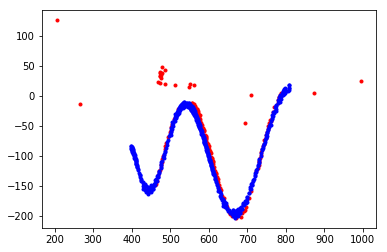

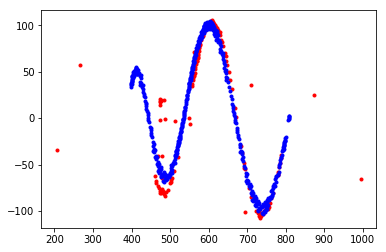

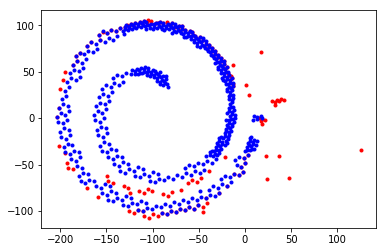

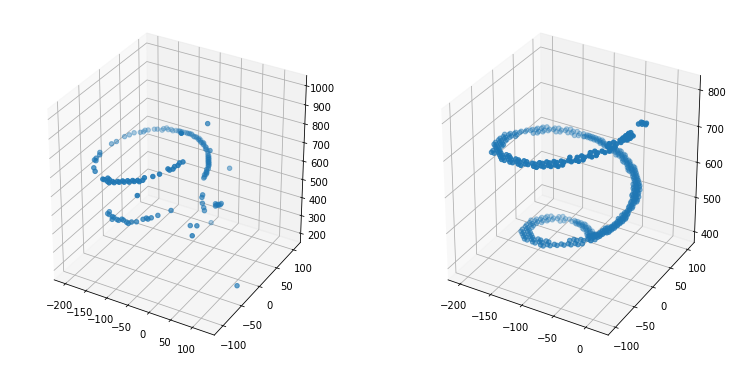

In [21]:
plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.')
plt.show()
plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.')
plt.show()
plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.')
plt.show()


fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,5],uvw_values[:,6],uvw_values[:,7])

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,5],sim_uvw_values[:,6],sim_uvw_values[:,7])